### Simple LSTM Models on skip_1, skip_2, skip_3 and not_skipped

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Conv1D, GlobalMaxPooling1D
from keras.optimizers import Adam

# Load datasets
tf_mini = pd.read_csv('/content/tf_mini.csv')
log_mini = pd.read_csv('/content/log_mini.csv')

# Merge datasets on track_id
merged_data = pd.merge(log_mini, tf_mini, left_on='track_id_clean', right_on='track_id')

# Print out column types to determine whether one-hot encoding is necessary or not
print(merged_data.dtypes)

session_id                          object
session_position                     int64
session_length                       int64
track_id_clean                      object
skip_1                                bool
skip_2                                bool
skip_3                                bool
not_skipped                           bool
context_switch                       int64
no_pause_before_play                 int64
short_pause_before_play              int64
long_pause_before_play               int64
hist_user_behavior_n_seekfwd         int64
hist_user_behavior_n_seekback        int64
hist_user_behavior_is_shuffle         bool
hour_of_day                          int64
date                                object
premium                               bool
context_type                        object
hist_user_behavior_reason_start     object
hist_user_behavior_reason_end       object
track_id                            object
duration                           float64
release_yea

In [3]:
# Change 'date' to datetime
merged_data['date'] = pd.to_datetime(merged_data['date'])
merged_data['day_of_week'] = merged_data['date'].dt.dayofweek
merged_data['month'] = merged_data['date'].dt.month
merged_data['duration'] = merged_data['duration'].astype(float)

# One-hot encode 'object' columns
categorical_columns = ['mode', 'context_type', 'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end']
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Assuming merged_data is your DataFrame and categorical_columns is the list of your categorical columns
encoder = OneHotEncoder(sparse_output=False)  # Note: 'sparse_output' replaces 'sparse'
merged_data_encoded = encoder.fit_transform(merged_data[categorical_columns])

# Use get_feature_names_out for newer versions of scikit-learn
merged_data_encoded_df = pd.DataFrame(merged_data_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Drop original categorical columns and concatenate the one-hot encoded columns
merged_data = merged_data.drop(categorical_columns, axis=1)
merged_data = pd.concat([merged_data, merged_data_encoded_df], axis=1)


In [4]:
# Drop origional categorical columns and other 'object' columns that do not provide useful information
merged_data = merged_data.drop(['session_id', 'track_id', 'track_id_clean', 'date'], axis=1)

In [5]:
print(merged_data.dtypes)

session_position                             int64
session_length                               int64
skip_1                                        bool
skip_2                                        bool
skip_3                                        bool
                                            ...   
hist_user_behavior_reason_end_endplay      float64
hist_user_behavior_reason_end_fwdbtn       float64
hist_user_behavior_reason_end_logout       float64
hist_user_behavior_reason_end_remote       float64
hist_user_behavior_reason_end_trackdone    float64
Length: 69, dtype: object


## Skip 1

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf

# Convert boolean target variable to an integer (0 or 1)
# False = 0, True = 1
merged_data['skipped'] = merged_data['skip_1'].astype(int)

# Separate the features and the target variable
X = merged_data.drop(['skip_1', 'skip_2', 'skip_3','not_skipped', 'skipped'], axis=1)  # Features
y = merged_data['skipped']  # Target variable -> skip_1

In [7]:
# Standardize the features (since features are all numerical and on different scales)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model
model = Sequential([
    Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                4224      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6337 (24.75 KB)
Trainable params: 6337 (24.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1679/1679 [==============================] - 5s 2ms/step - loss: 0.3753 - accuracy: 0.8435 - val_loss: 0.2937 - val_accuracy: 0.8808
Epoch 2/10
1679/1679 [==============================] - 4s 2ms/step - loss: 0.3112 - accuracy: 0.8781 - val_loss: 0.2872 - val_accuracy: 0.8830
Epoch 3/10
1679/1679 [==============================] - 5s 3ms/step - loss: 0.3032 - accuracy: 0.8796 - val_loss: 0.2828 - val_accuracy: 0.8851
Epoch 4/10
1679/1679 [==============================] - 4s 2ms/step - loss: 0.2984 - accuracy: 0.8813 - val_loss: 0.2826 - val_accuracy: 0.8869
Epoch 5/10
1679/1679 [==============================] - 4s 2ms/step - loss: 0.2955 - accuracy: 0.8825 - val_loss: 0.2828 - val_accuracy: 0.8863
Epoch 6/10
1679/1679 [==============================] - 5s 3ms/step - loss: 0.2940 - accuracy: 0.8834 - val_loss: 0.2812 - val_accuracy: 0.8867
Epoch 7/10
1679/1679 [==============================] - 4s 2ms/step - loss: 0.2942 - accuracy: 0.8838 - val_loss: 0.2807 - val_accuracy:

In [10]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

1050/1050 [==============================] - 1s 1ms/step - loss: 0.2865 - accuracy: 0.8831
Test Loss: 0.28653568029403687, Test Accuracy: 0.8831307888031006


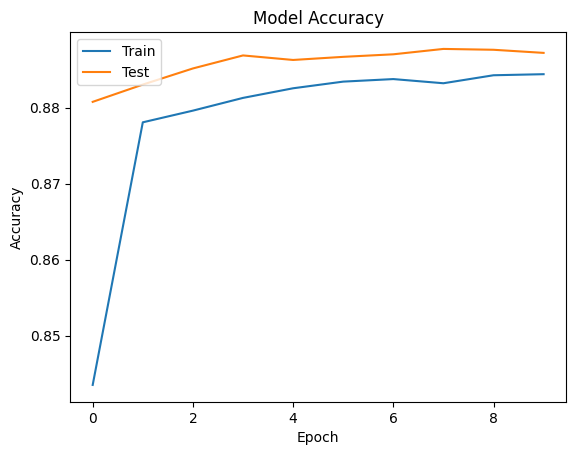

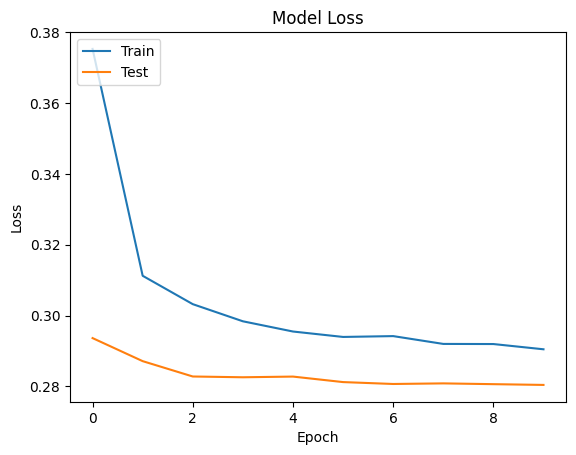

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Skip 2

In [12]:
# False = 0, True = 1
merged_data['skipped'] = merged_data['skip_2'].astype(int)

# Separate the features and the target variable
X2 = merged_data.drop(['skip_1', 'skip_2', 'skip_3','not_skipped', 'skipped'], axis=1)  # Features
y2 = merged_data['skipped']  # Target variable -> skip_2

In [13]:
# Standardize the features (since features are all numerical and on different scales)
scaler = StandardScaler()
X2 = scaler.fit_transform(X2)

# Split the data into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Define the model
model2 = Sequential([
    Dense(64, input_shape=(X2_train.shape[1],), activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model2.summary()

# Train the model
history2 = model2.fit(X2_train, y2_train, epochs=10, batch_size=64, validation_split=0.2)

loss2, accuracy2 = model2.evaluate(X2_test, y2_test)
print(f'Test Loss: {loss2}, Test Accuracy: {accuracy2}')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                4224      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6337 (24.75 KB)
Trainable params: 6337 (24.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1679/1679

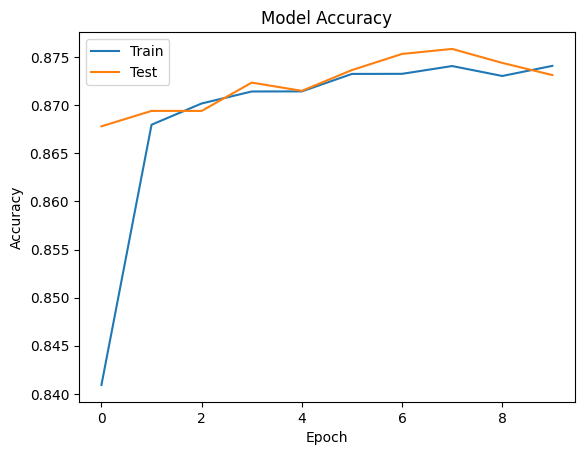

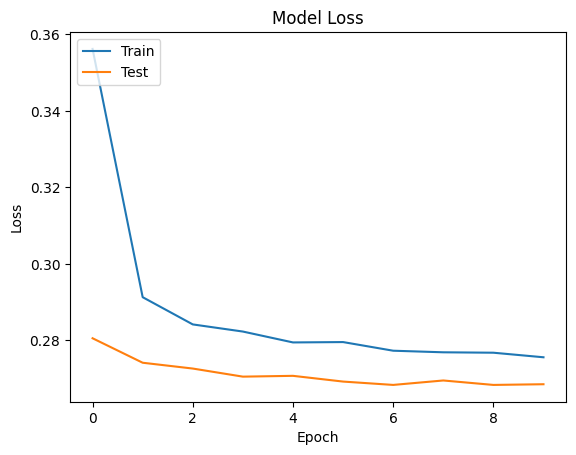

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Skip 3

In [15]:
# False = 0, True = 1
merged_data['skipped'] = merged_data['skip_3'].astype(int)

# Separate the features and the target variable
X3 = merged_data.drop(['skip_1', 'skip_2', 'skip_3','not_skipped', 'skipped'], axis=1)  # Features
y3 = merged_data['skipped']  # Target variable -> skip_3

In [16]:
# Standardize the features (since features are all numerical and on different scales)
scaler = StandardScaler()
X3 = scaler.fit_transform(X3)

# Split the data into training and testing sets
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

# Define the model
model3 = Sequential([
    Dense(64, input_shape=(X3_train.shape[1],), activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model3.summary()

# Train the model
history3 = model3.fit(X3_train, y3_train, epochs=10, batch_size=64, validation_split=0.2)

loss3, accuracy3 = model2.evaluate(X3_test, y3_test)
print(f'Test Loss: {loss3}, Test Accuracy: {accuracy3}')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                4224      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6337 (24.75 KB)
Trainable params: 6337 (24.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1679/1679

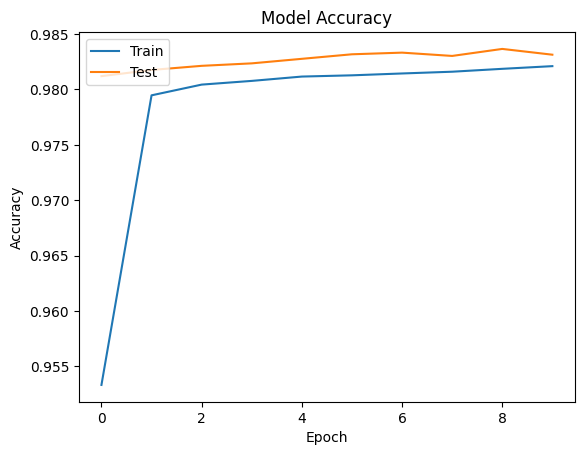

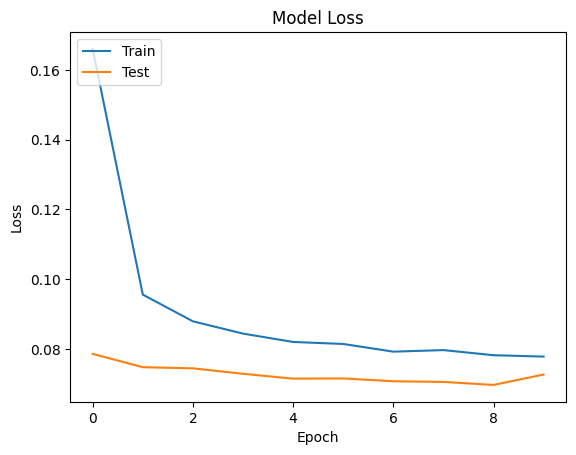

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Not Skipped

In [18]:
# False = 0, True = 1
merged_data['skipped'] = merged_data['not_skipped'].astype(int)

# Separate the features and the target variable
X4 = merged_data.drop(['skip_1', 'skip_2', 'skip_3','not_skipped', 'skipped'], axis=1)  # Features
y4 = merged_data['skipped']  # Target variable -> not_skipped

In [19]:
# Standardize the features (since features are all numerical and on different scales)
scaler = StandardScaler()
X4 = scaler.fit_transform(X4)

# Split the data into training and testing sets
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42)

# Define the model
model4 = Sequential([
    Dense(64, input_shape=(X4_train.shape[1],), activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model4.summary()

# Train the model
history4 = model4.fit(X4_train, y4_train, epochs=10, batch_size=64, validation_split=0.2)

loss4, accuracy4 = model4.evaluate(X4_test, y4_test)
print(f'Test Loss: {loss4}, Test Accuracy: {accuracy4}')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                4224      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6337 (24.75 KB)
Trainable params: 6337 (24.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1679/1679

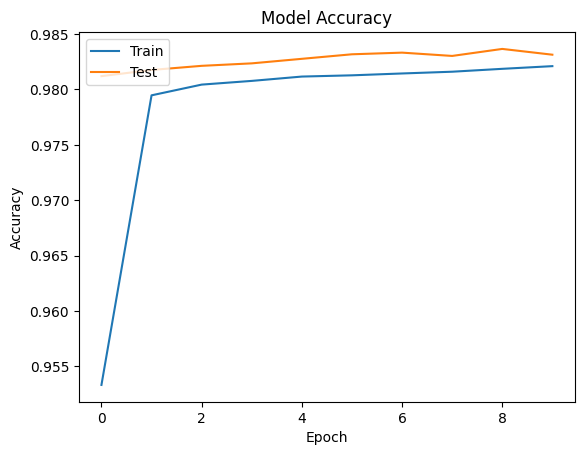

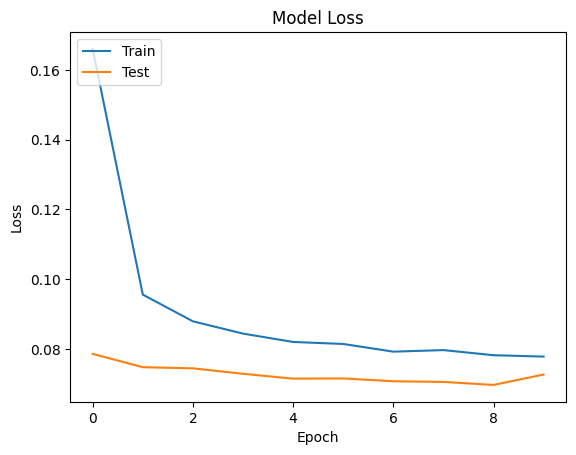

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()